In [41]:
!mkdir -p data/oxford_pets
!tar -xzf images.tar.gz -C data/oxford_pets/
!tar -xzf annotations.tar.gz -C data/oxford_pets/

In [42]:
import os
import tensorflow as tf
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [43]:

# Set image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Paths
IMAGE_DIR = '/home/nikola/Documents/Assignment-8/data/oxford_pets/images'
MASK_DIR = '/home/nikola/Documents/Assignment-8/data/oxford_pets/annotations/trimaps'

def load_image_mask(image_path):
    # Read and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    # Get filename and build mask path
    filename = tf.strings.split(image_path, os.sep)[-1]
    filename = tf.strings.regex_replace(filename, '.jpg', '.png')
    mask_path = tf.strings.join([MASK_DIR, filename], separator=os.sep)

    # Read and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method='nearest')
    # The original masks have values 1, 2, 3 — subtract 1 to get 0-based class indices
    mask = tf.cast(mask, tf.uint8) - 1

    return image, mask


In [44]:
# List all image files
image_paths = tf.io.gfile.glob(os.path.join(IMAGE_DIR, '*.jpg'))

# Split dataset: 80% train, 20% test
num_images = len(image_paths)
train_size = int(0.8 * num_images)
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [45]:
# U-Net model
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder
    x1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)

    x2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    x2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(x2)

    x3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    x3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(x3)

    x4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    x4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(x4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(x4)

    # Bottleneck
    bn = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    bn = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same')(bn)
    u1 = tf.keras.layers.concatenate([u1, x4])
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(u1)
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(u1)

    u2 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same')(u1)
    u2 = tf.keras.layers.concatenate([u2, x3])
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u2)
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u2)

    u3 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(u2)
    u3 = tf.keras.layers.concatenate([u3, x2])
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u3)
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u3)

    u4 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(u3)
    u4 = tf.keras.layers.concatenate([u4, x1])
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u4)
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u4)

    outputs = tf.keras.layers.Conv2D(3, 1, activation='softmax')(u4)

    return tf.keras.Model(inputs, outputs)


In [51]:
with tf.device('/GPU:0'):
    model = unet_model(output_channels=3)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_dataset, epochs=10, validation_data=test_dataset)


Epoch 1/10
134/185 [====================>.........] - ETA: 8:24 - loss: 0.9240 - accuracy: 0.5830

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.9053 - accuracy: 0.5861

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1948s 11s/step - loss: 0.9053 - accuracy: 0.5861 - val_loss: 0.8370 - val_accuracy: 0.5853
Epoch 2/10
134/185 [====================>.........] - ETA: 8:15 - loss: 0.7916 - accuracy: 0.6293

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.6503

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1882s 10s/step - loss: 0.7666 - accuracy: 0.6503 - val_loss: 0.6395 - val_accuracy: 0.7393
Epoch 3/10
134/185 [====================>.........] - ETA: 7:59 - loss: 0.6251 - accuracy: 0.7481

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.7518

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1844s 10s/step - loss: 0.6174 - accuracy: 0.7518 - val_loss: 0.5636 - val_accuracy: 0.7801
Epoch 4/10
134/185 [====================>.........] - ETA: 7:53 - loss: 0.5228 - accuracy: 0.7970

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7996

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1826s 10s/step - loss: 0.5169 - accuracy: 0.7996 - val_loss: 0.4851 - val_accuracy: 0.8092
Epoch 5/10
134/185 [====================>.........] - ETA: 7:54 - loss: 0.4415 - accuracy: 0.8304

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8302

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1834s 10s/step - loss: 0.4409 - accuracy: 0.8302 - val_loss: 0.3971 - val_accuracy: 0.8461
Epoch 6/10
134/185 [====================>.........] - ETA: 7:57 - loss: 0.3991 - accuracy: 0.8464

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8459

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1839s 10s/step - loss: 0.4020 - accuracy: 0.8459 - val_loss: 0.3802 - val_accuracy: 0.8543
Epoch 7/10
134/185 [====================>.........] - ETA: 7:56 - loss: 0.3659 - accuracy: 0.8604

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8617

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1837s 10s/step - loss: 0.3624 - accuracy: 0.8617 - val_loss: 0.3678 - val_accuracy: 0.8613
Epoch 8/10
134/185 [====================>.........] - ETA: 7:56 - loss: 0.3364 - accuracy: 0.8712

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8705

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1837s 10s/step - loss: 0.3377 - accuracy: 0.8705 - val_loss: 0.3394 - val_accuracy: 0.8694
Epoch 9/10
134/185 [====================>.........] - ETA: 7:56 - loss: 0.3203 - accuracy: 0.8778

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8775

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1836s 10s/step - loss: 0.3211 - accuracy: 0.8775 - val_loss: 0.3378 - val_accuracy: 0.8728
Epoch 10/10
134/185 [====================>.........] - ETA: 7:57 - loss: 0.2996 - accuracy: 0.8852

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8847

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - 1876s 10s/step - loss: 0.3014 - accuracy: 0.8847 - val_loss: 0.3344 - val_accuracy: 0.8751


1/1 [==============================] - 3s 3s/step


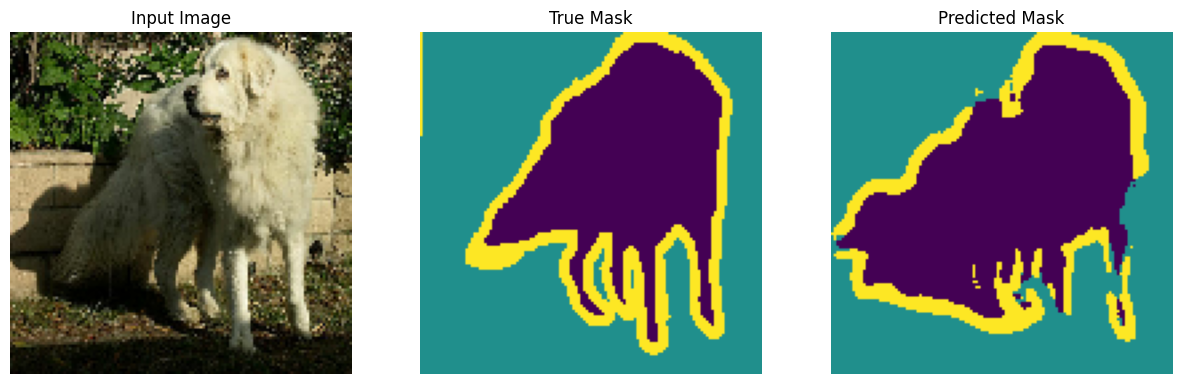

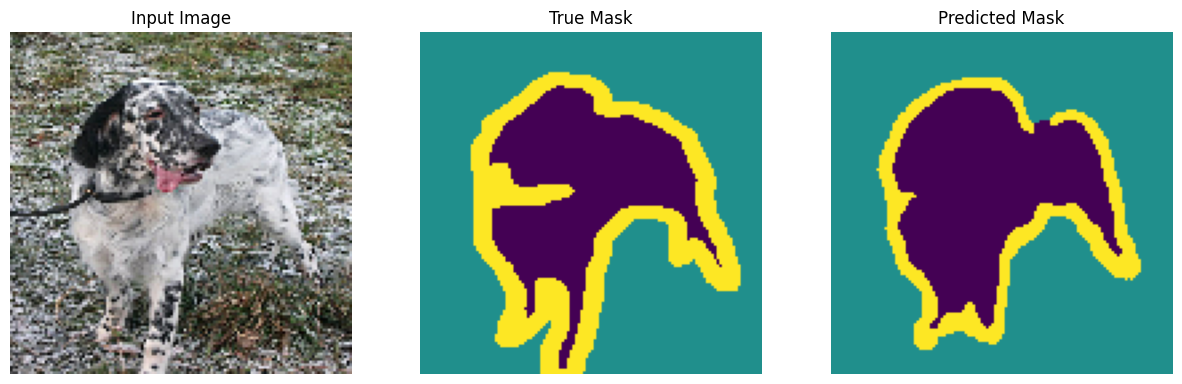

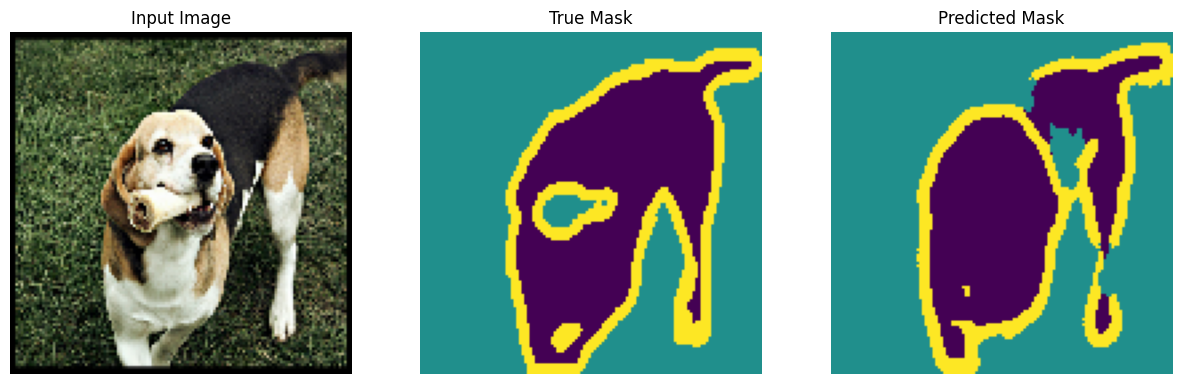

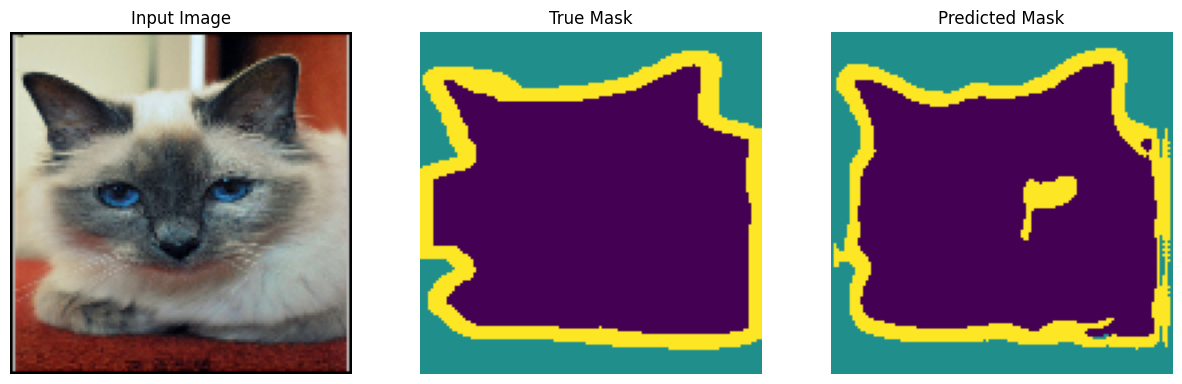

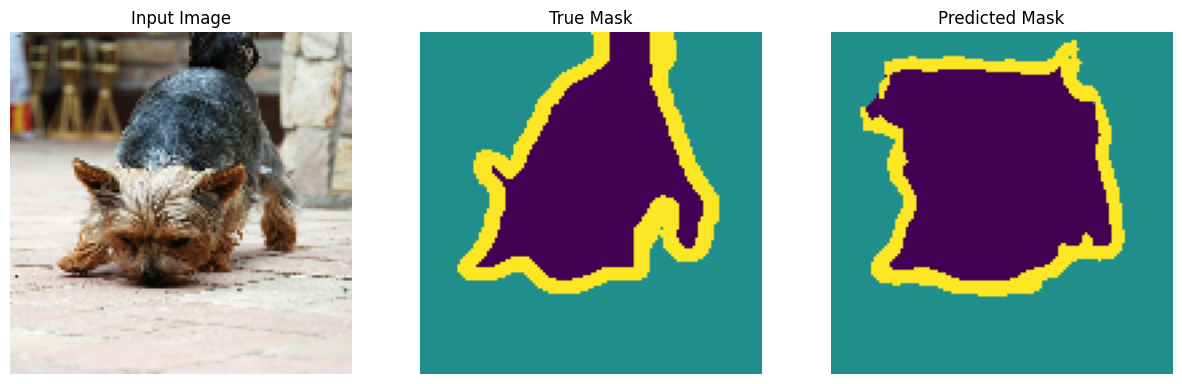

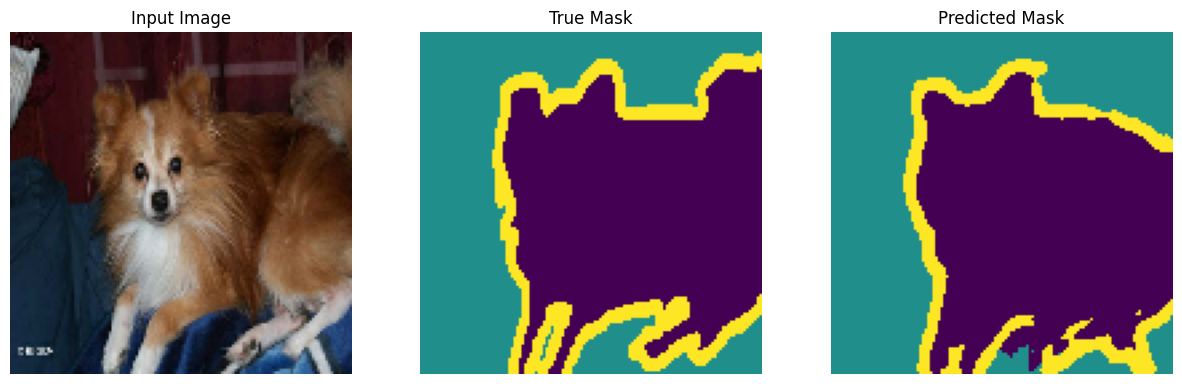

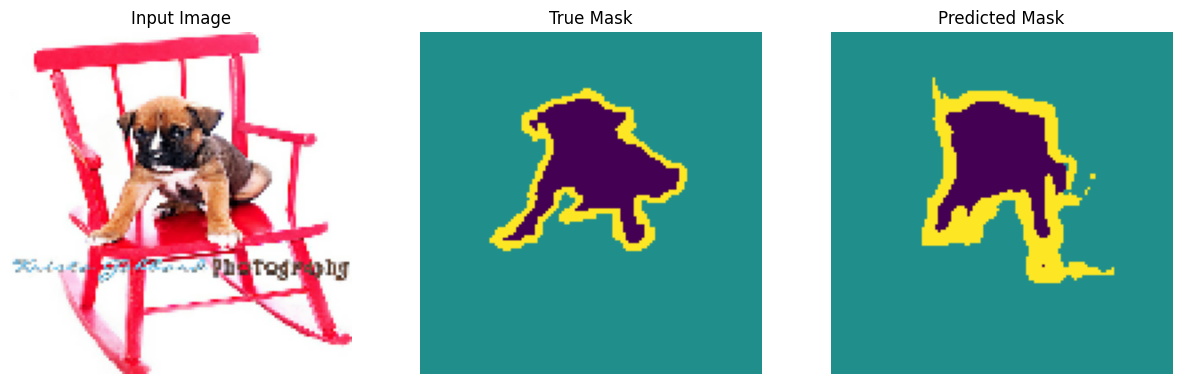

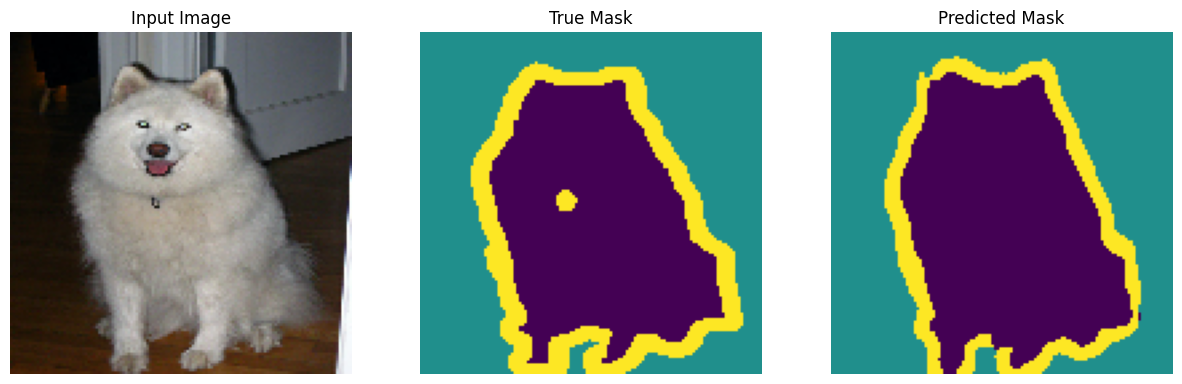

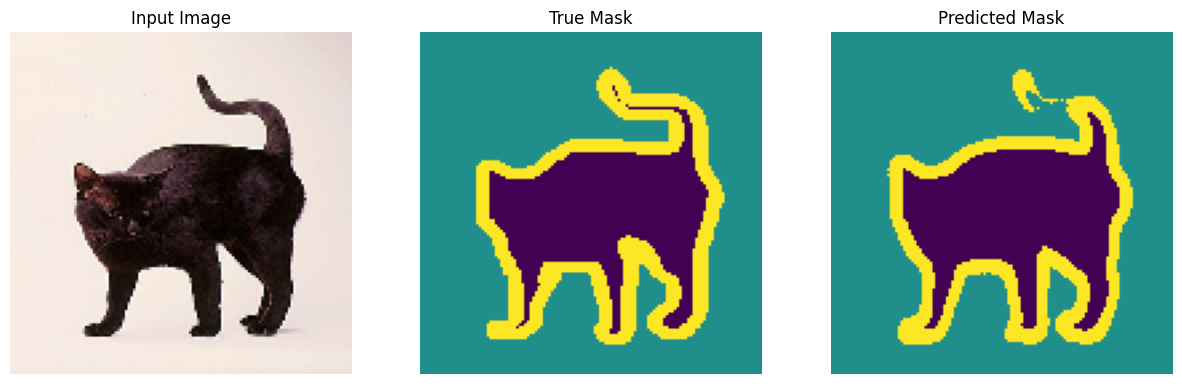

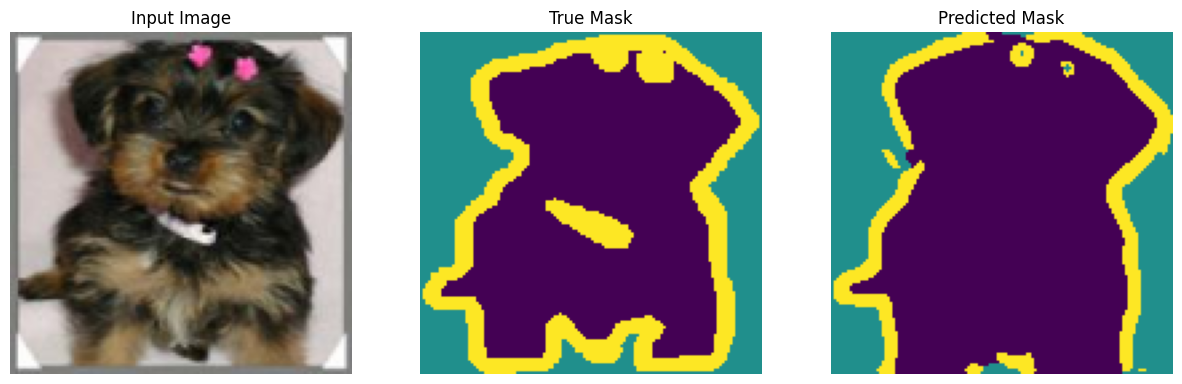

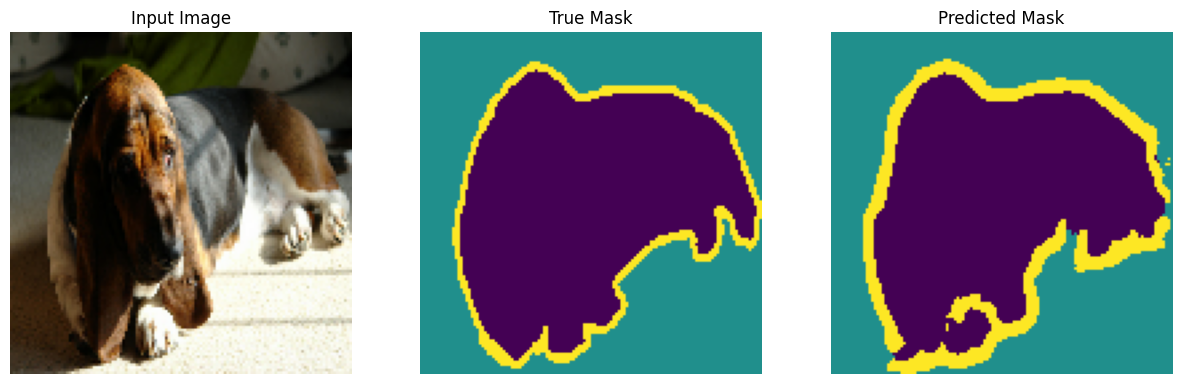

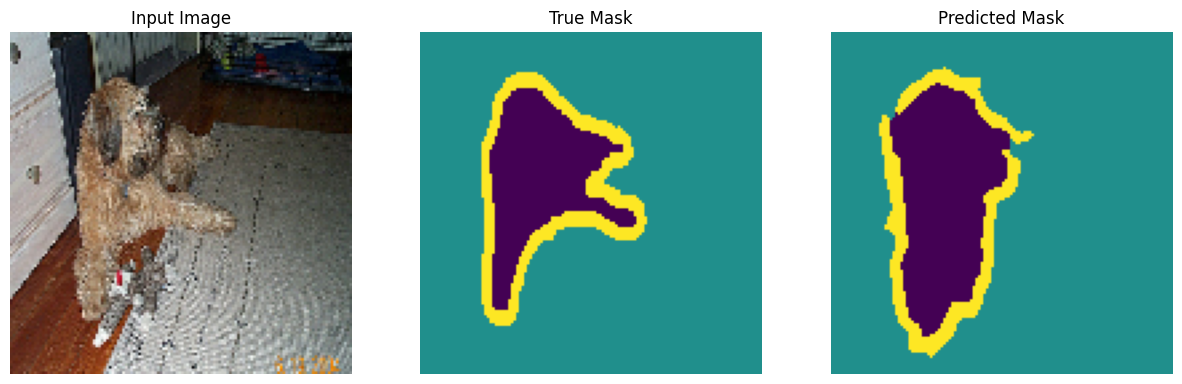

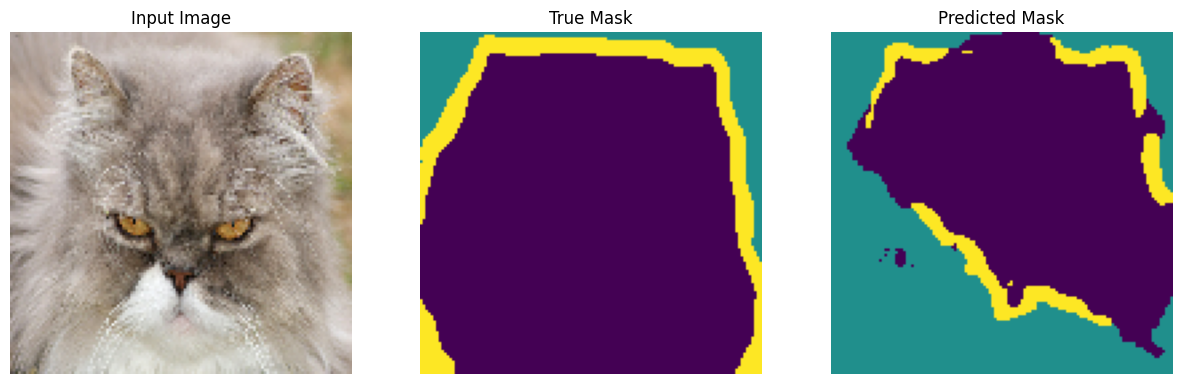

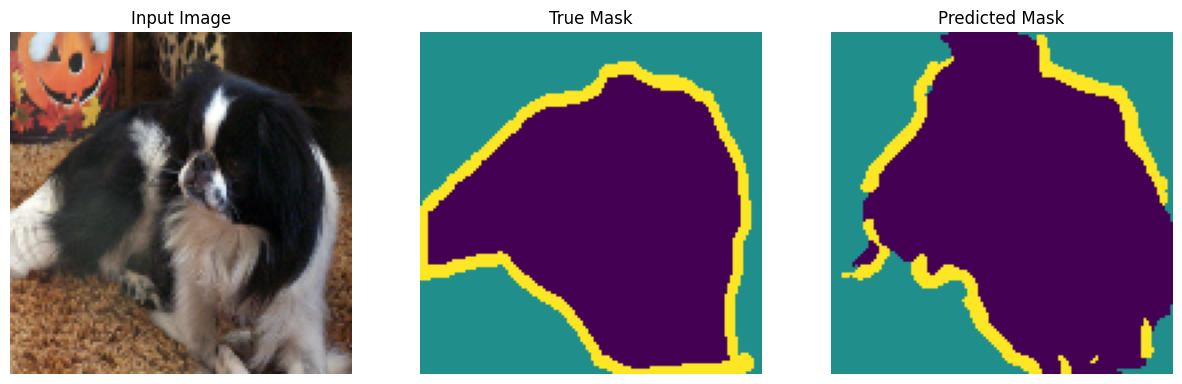

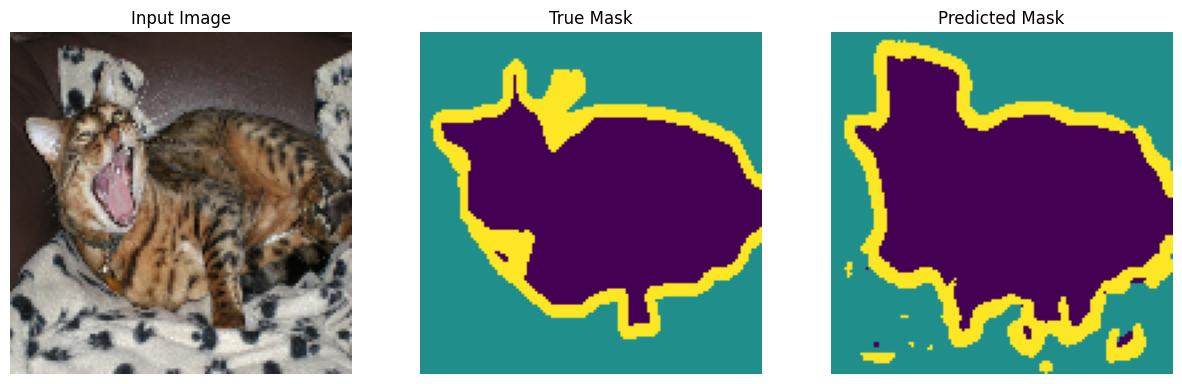

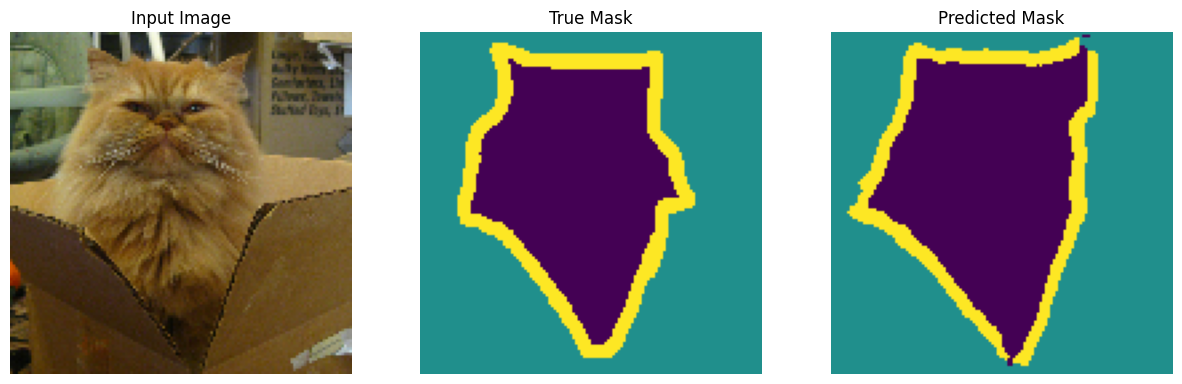

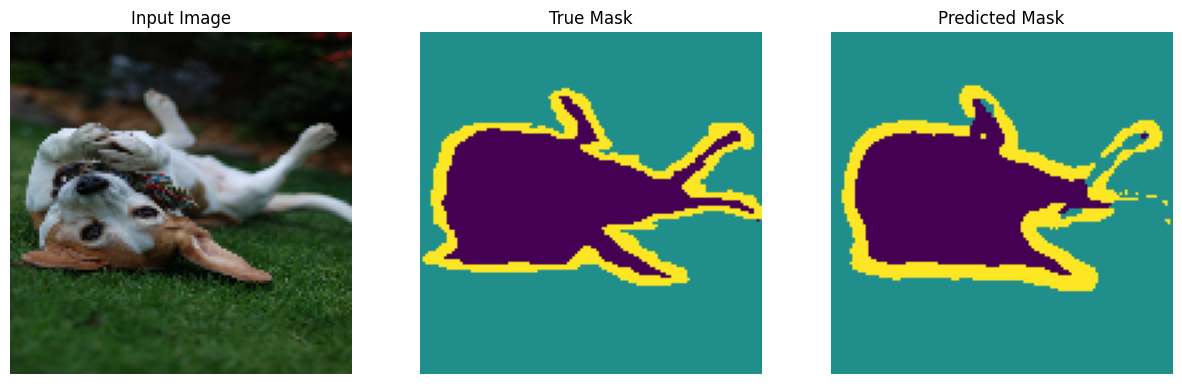

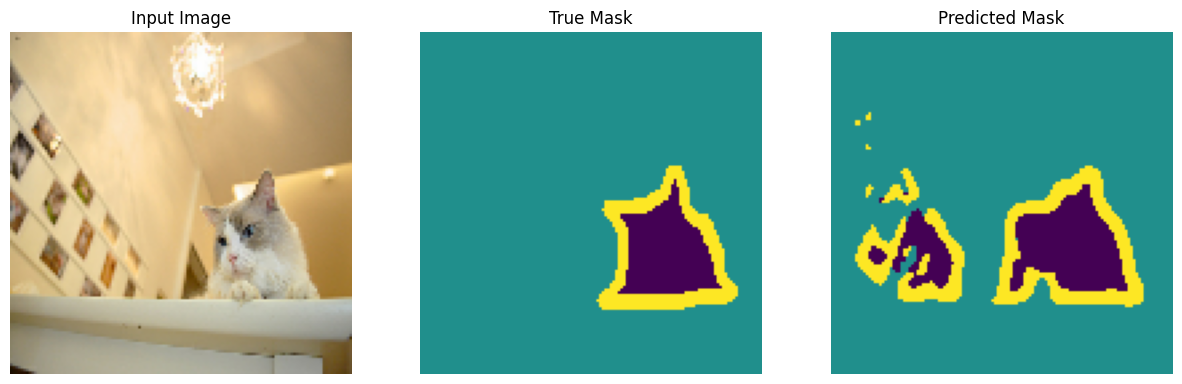

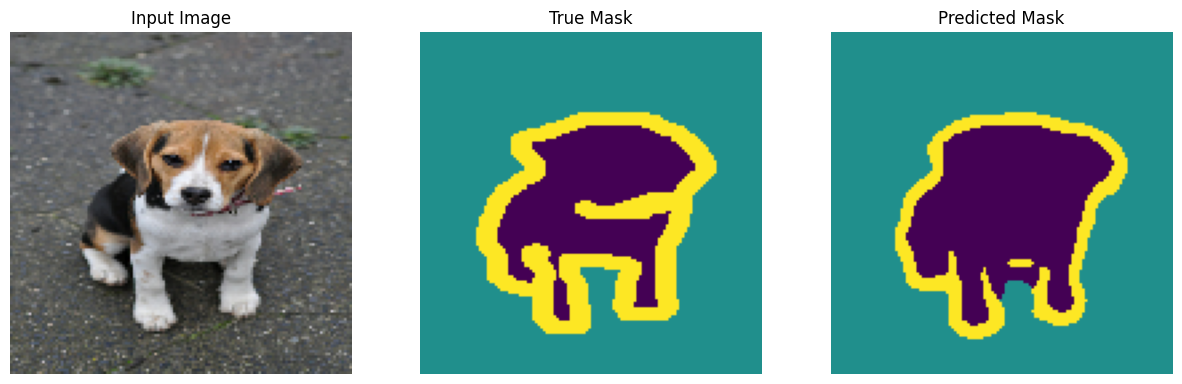

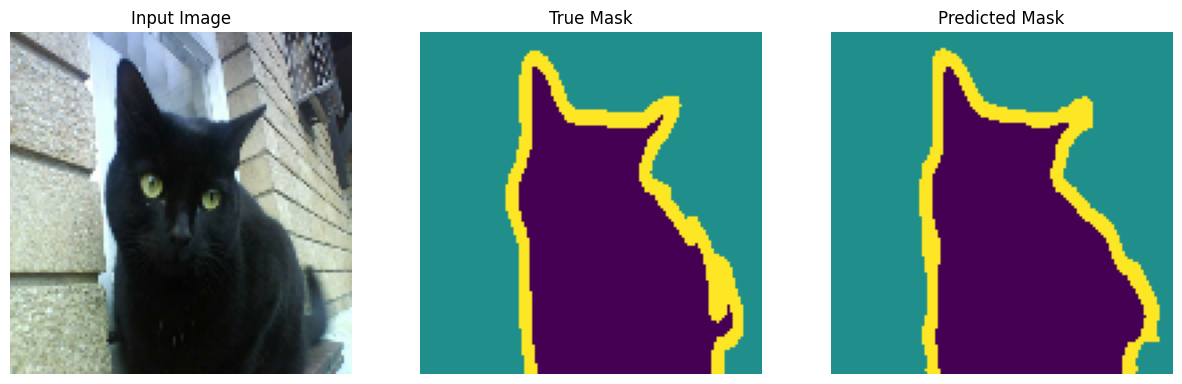

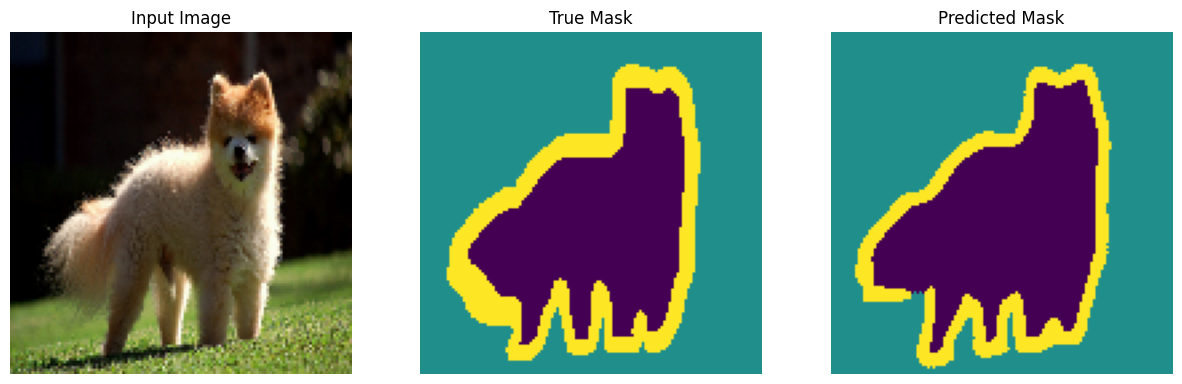

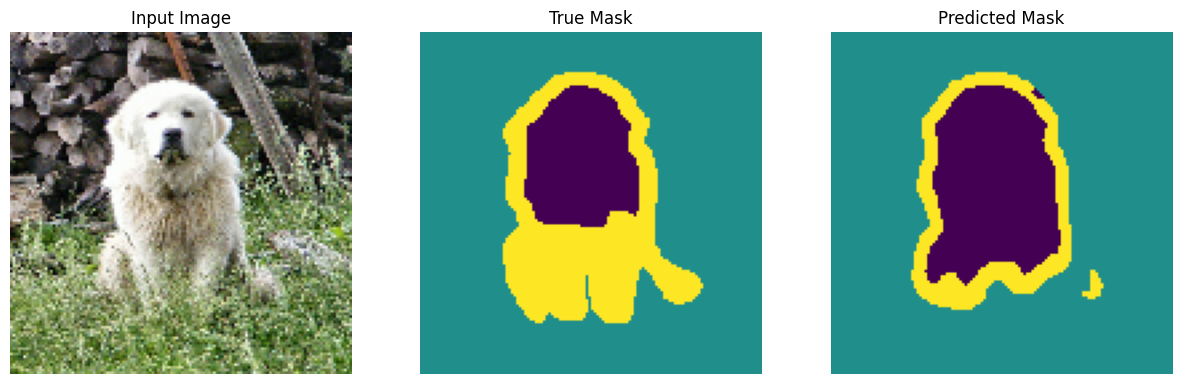

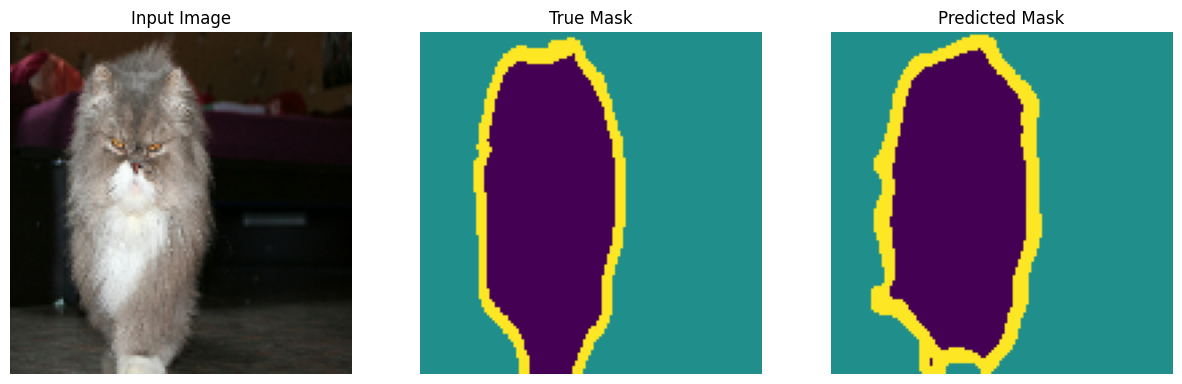

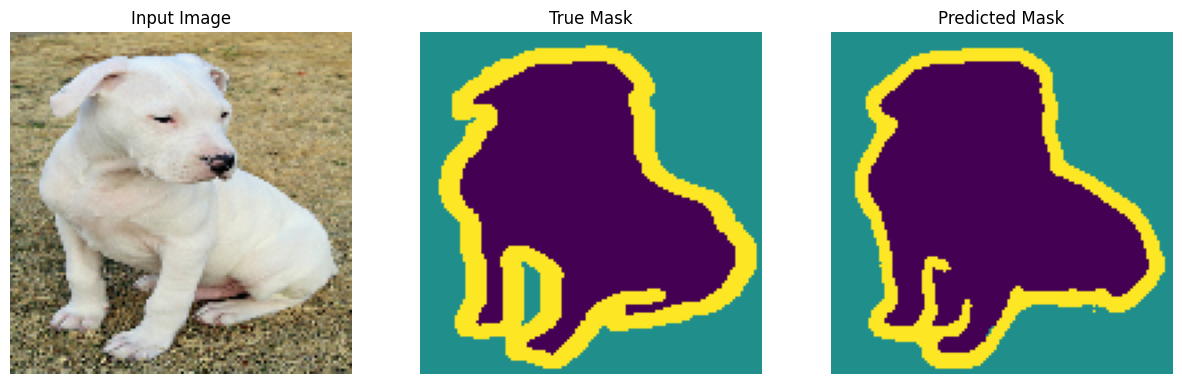

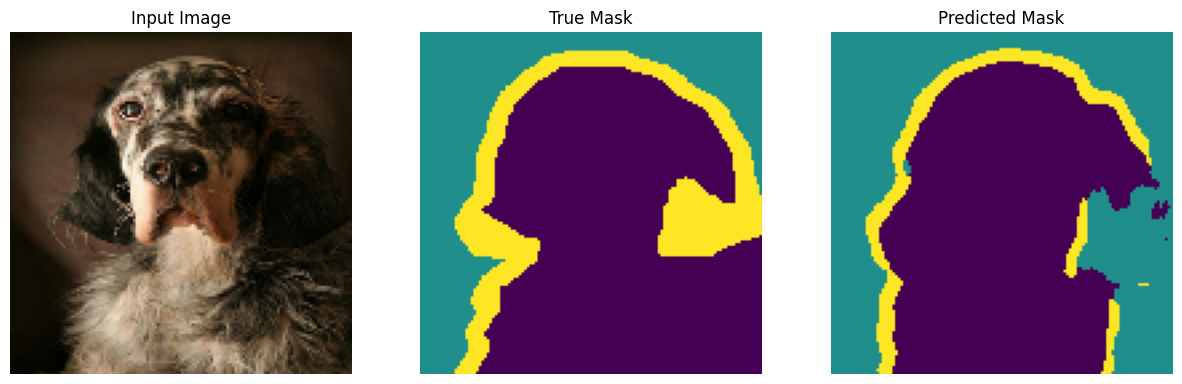

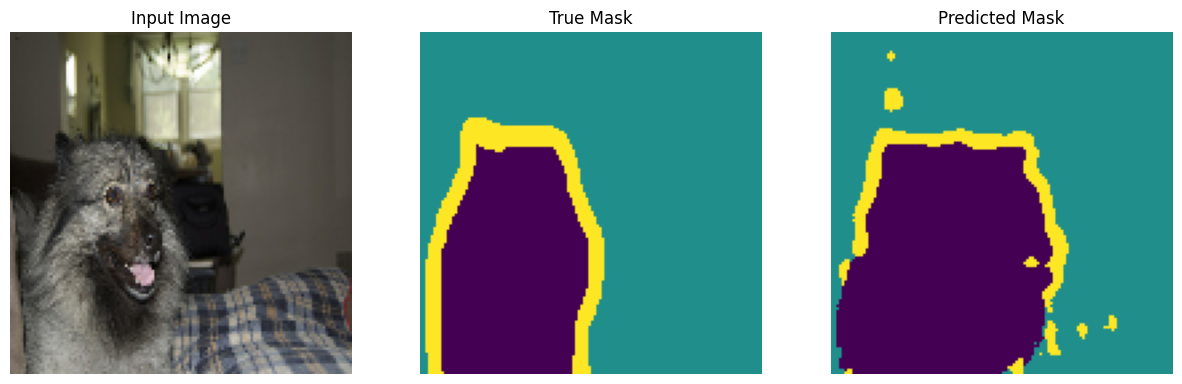

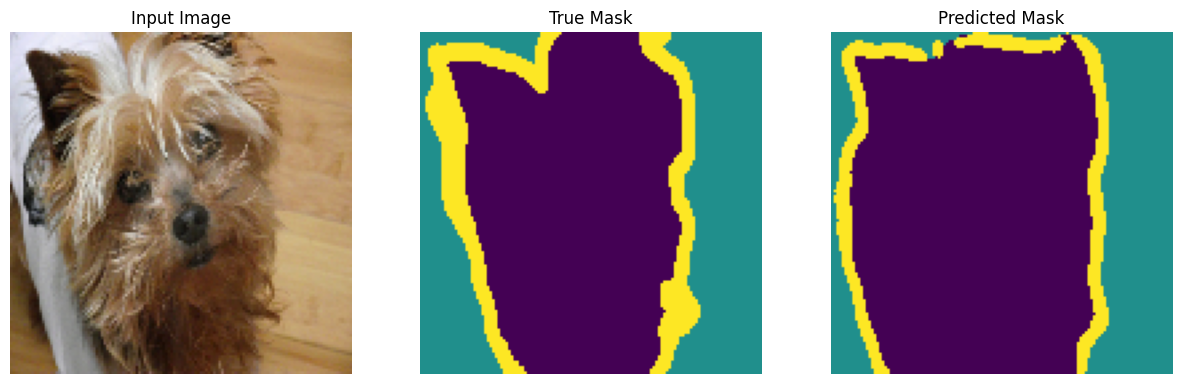

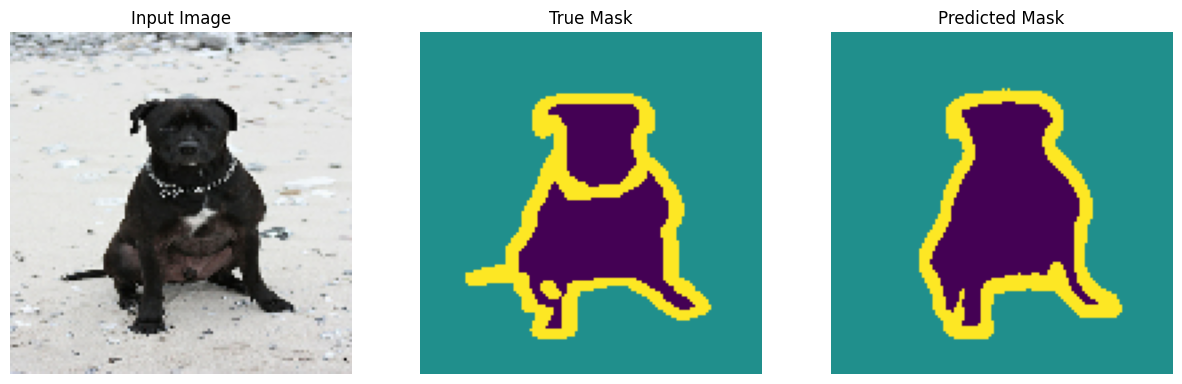

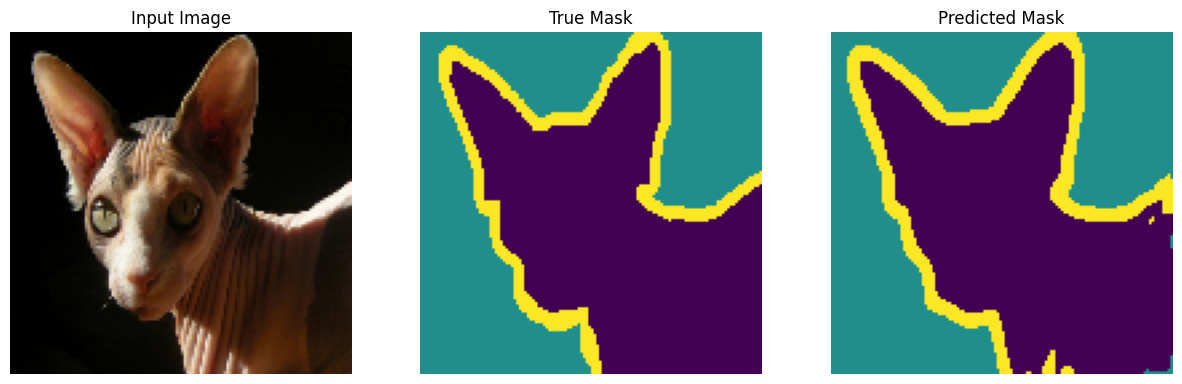

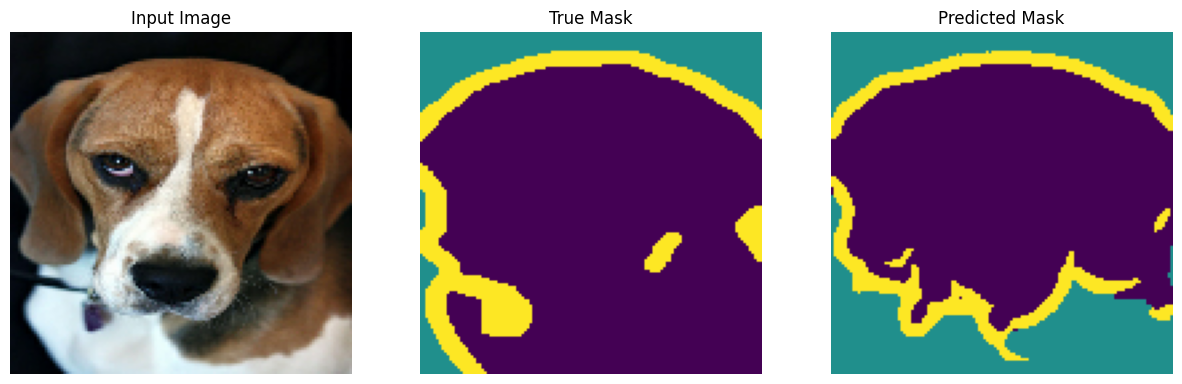

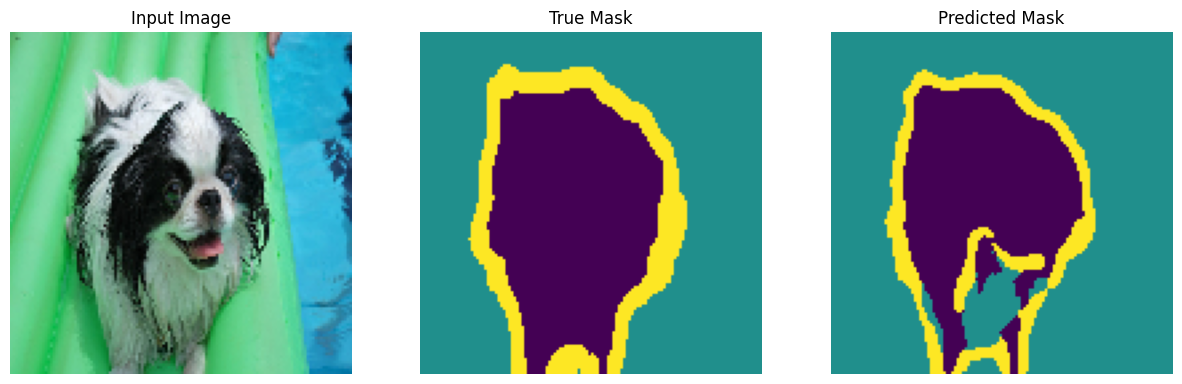

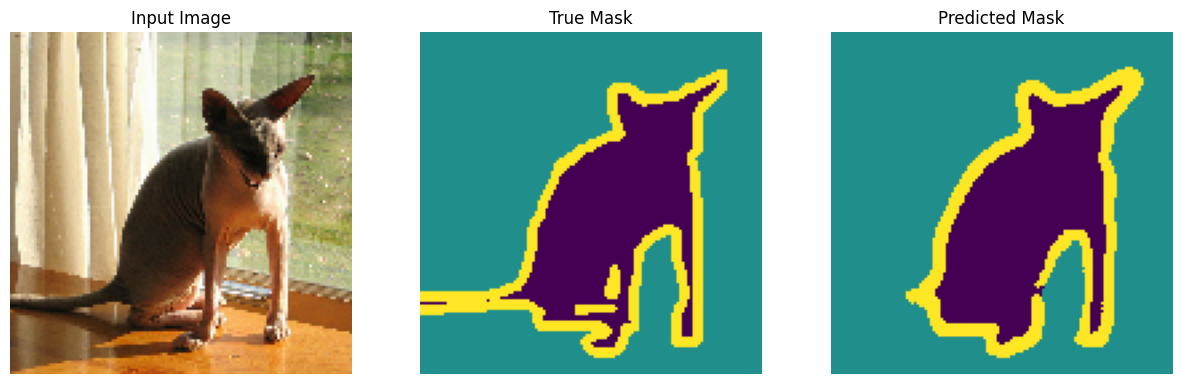

In [52]:
# 📌 STEP 7: Visualize predictions
def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)[..., tf.newaxis]

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        for i in range(len(image)):
            display([image[i], mask[i], create_mask(pred_mask[i])])

show_predictions(test_dataset, num=1)
